### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

from scipy.stats import pearsonr


## code for mfdataset/ extracting raw TS

    1. make_mfdat

        takes: yearlist of diad_T model output

        outputs: full ts of 2d global fields

        `(f'./GCBdata/{nornam}_*{yrst}_*{yrend}_qtrB14b.nc')`

        `(f'./GCBdata/{nornam}_*{yrst}_*{yrend}_Cflx.nc')`

    2. extract_ts

        takes: output from make_mfdat above

        outputs: 1d ts with nice times, not smoothed

## mask_42 is a subset of mask_band

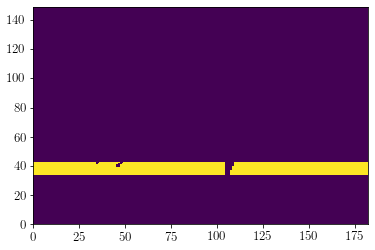

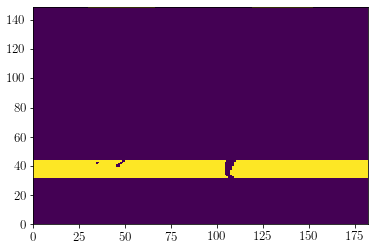

In [4]:
tmeshf = './obs/mmask.nc'
tmesh = xr.open_dataset(tmeshf)
masknams = ['mask_so','mask_so50','mask_smol','mask_wide','mask_band']

tmask42 = np.zeros_like(tmesh.mask_smol)
tmask42[34:43,:] = tmesh.mask_band[34:43,:]
tmesh

var_copy = tmesh['mask_so'].copy()
var_copy.name = 'mask_42'
var_copy.data = tmask42
tmesh['mask_42'] =var_copy

plt.figure()
plt.pcolormesh(tmesh.mask_42)

plt.figure()
plt.pcolormesh(tmesh.mask_band)
#tmesh['tmask42'] = tmask42

#tmesh.to_netcdf('./obs/mmask_42.nc')


In [5]:
yrst = 1940; yrend = 2022
extract = False

def make_yearlist(yrst, yrend, dtype, tr, baseDir = '/gpfs/data/greenocean/software/runs/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/TOM12_TJ_{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

def make_mfdat(yrst,yrend,nornam):

    nor = xr.open_mfdataset(make_yearlist(yrst,yrend,'diad_T',nornam))
    nor.qtrB14b.to_netcdf(f'./GCBdata/{nornam}_{yrst}_{yrend}_qtrB14b.nc')
    nor.Cflx.to_netcdf(f'./GCBdata/{nornam}_{yrst}_{yrend}_Cflx.nc')
    print(f'made for {nornam}')
    
    
def extract_ts(tdir,yrst = 1948,yrend = 2019, savenam = True):
    
    print('go')

    sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data'
    C14d_qtr_c14 = xr.open_dataset(f'./GCBdata/{tdir}_{yrst}_{yrend}_qtrB14b.nc')   ##static
    C14d_Cflx = xr.open_dataset(f'./GCBdata/{tdir}_{yrst}_{yrend}_Cflx.nc') ###static

    times = pd.date_range(f'{yrst}/01/01',f'{yrend}/12/31',freq='MS')

    ### -------- B) get areas/grid variables

    tmeshf = './obs/mmask_42.nc'
    tmesh = xr.open_dataset(tmeshf)
    #masknams = ['mask_so','mask_so50','mask_smol','mask_wide','mask_band']
    masknams = ['mask_42']
    for m in range(0,len(masknams)):
        masknam = masknams[m]
        area =  tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:] * tmesh[masknam][:,:]

        qtrnewt_D = C14d_qtr_c14.qtrB14b * area.values* 3.156e7 *2 *1e-14 *6.023e23*1e-26 #some horrible unit conversion taht corrine understands
        cflxnewt_D = C14d_Cflx.Cflx * area.values* 3.156e7*12e-15  #mol/m2/s > pg/yr

        qtrnewt_D['time_counter'] = times
        cflxnewt_D['time_counter'] = times

        qtrflx_mn_D = qtrnewt_D.sum(dim = ['x','y'])
        cflxint_mn_D = cflxnewt_D.sum(dim = ['x','y'])
        
        if savenam:
            qtrflx_mn_D.to_netcdf(f'{sdir}/qtr_{tdir}_{yrst}_{yrend}_{masknam}_ts.nc')
            cflxint_mn_D.to_netcdf(f'{sdir}/cflx_{tdir}_{yrst}_{yrend}_{masknam}_ts.nc')
        print(f'saved ts for {tdir}')
   
def extract_ts_avg(tdir,yrst = 1948,yrend = 2019, savenam = True):
    
    print('go')

    sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data'
    C14d_qtr_c14 = xr.open_dataset(f'./GCBdata/{tdir}_{yrst}_{yrend}_qtrB14b.nc')   ##static
    C14d_Cflx = xr.open_dataset(f'./GCBdata/{tdir}_{yrst}_{yrend}_Cflx.nc') ###static

    times = pd.date_range(f'{yrst}/01/01',f'{yrend}/12/31',freq='MS')

    ### -------- B) get areas/grid variables

    tmeshf = './obs/mmask_42.nc'
    tmesh = xr.open_dataset(tmeshf)
    #masknams = ['mask_so','mask_so50','mask_smol','mask_wide','mask_band']
    masknams = ['mask_42']
    for m in range(0,len(masknams)):
        masknam = masknams[m]
        area =  tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:] * tmesh[masknam][:,:]

        
        
        qtrnewt_D = C14d_qtr_c14.qtrB14b * area.values* 3.156e7 *2 *1e-14 *6.023e23*1e-26 #some horrible unit conversion taht corrine understands
        cflxnewt_D = C14d_Cflx.Cflx * area.values* 3.156e7*12e-15  #mol/m2/s > pg/yr

        qtrnewt_D['time_counter'] = times
        cflxnewt_D['time_counter'] = times

        qtrflx_mn_D = qtrnewt_D.sum(dim = ['x','y'])
        cflxint_mn_D = cflxnewt_D.sum(dim = ['x','y'])
        
        if savenam:
            qtrflx_mn_D.to_netcdf(f'{sdir}/qtr_{tdir}_{yrst}_{yrend}_{masknam}_ts.nc')
            cflxint_mn_D.to_netcdf(f'{sdir}/cflx_{tdir}_{yrst}_{yrend}_{masknam}_ts.nc')
        print(f'saved ts for {tdir}')



if extract:
    
    #make_mfdat(1950,2022,'SECT')
    #print('done')
    # make_mfdat(1950,2022,'SEA0')
    # make_mfdat(1950,2022,'SNCT')
    # make_mfdat(1950,2022,'SNA0')


    extract_ts('SECT',yrst = 1950,yrend = 2022)
    extract_ts('SEA0',yrst = 1950,yrend = 2022)
    extract_ts('SNCT',yrst = 1950,yrend = 2022)
    extract_ts('SNA0',yrst = 1950,yrend = 2022)

## get it in /ms/s and save

In [6]:
#def extract_ts_avg(tdir,yrst = 1948,yrend = 2019, savenam = True):
savenam = False


yrst = 1950; yrend = 2022

def extract_ts_avg(tdir,yrst = 1950,yrend = 2022, savenam = True):

    print('go')

    sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data'
    C14d_qtr_c14 = xr.open_dataset(f'./GCBdata/{tdir}_{yrst}_{yrend}_qtrB14b.nc')   ##static
    C14d_Cflx = xr.open_dataset(f'./GCBdata/{tdir}_{yrst}_{yrend}_Cflx.nc') ###static

    times = pd.date_range(f'{yrst}/01/01',f'{yrend}/12/31',freq='MS')

    ### -------- B) get areas/grid variables

    tmeshf = './obs/mmask_42.nc'
    tmesh = xr.open_dataset(tmeshf)
    #masknams = ['mask_so','mask_so50','mask_smol','mask_wide','mask_band']
    masknams = ['mask_42','mask_band']
    for m in range(0,len(masknams)):
        masknam = masknams[m]
        area =  tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:] * tmesh[masknam][:,:]
        print(np.nansum(area))
        #qtrnewt_D = C14d_qtr_c14.qtrB14b.weighted(area).mean(dim = ['x','y']) #t conversion taht corrine understands
        cflxnewt_D = C14d_Cflx.Cflx.weighted(area).mean(dim = ['x','y']) ## #mol/m2/s > pg/yr
        cflxnewt_D['time_counter'] = times


        if savenam:
            cflxnewt_D.to_netcdf(f'{sdir}/cflx_{tdir}_{yrst}_{yrend}_{masknam}_ts_mean.nc')
            print(f'saved ts for {tdir}')
            print(f'cflx_{tdir}_{yrst}_{yrend}_{masknam}_ts_mean.nc')

extract_ts_avg('SECT',yrst = 1950,yrend = 2022)
extract_ts_avg('SEA0',yrst = 1950,yrend = 2022)
extract_ts_avg('SNCT',yrst = 1950,yrend = 2022)
extract_ts_avg('SNA0',yrst = 1950,yrend = 2022)

go
36147033447467.53
saved ts for SECT
cflx_SECT_1950_2022_mask_42_ts_mean.nc
47737042946685.79
saved ts for SECT
cflx_SECT_1950_2022_mask_band_ts_mean.nc
go
36147033447467.53
saved ts for SEA0
cflx_SEA0_1950_2022_mask_42_ts_mean.nc
47737042946685.79
saved ts for SEA0
cflx_SEA0_1950_2022_mask_band_ts_mean.nc
go
36147033447467.53
saved ts for SNCT
cflx_SNCT_1950_2022_mask_42_ts_mean.nc
47737042946685.79
saved ts for SNCT
cflx_SNCT_1950_2022_mask_band_ts_mean.nc
go
36147033447467.53
saved ts for SNA0
cflx_SNA0_1950_2022_mask_42_ts_mean.nc
47737042946685.79
saved ts for SNA0
cflx_SNA0_1950_2022_mask_band_ts_mean.nc


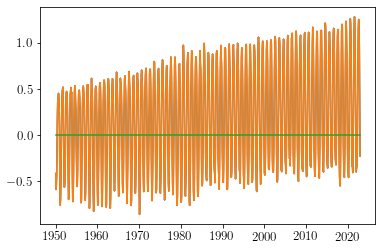

In [25]:
sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data'
w = xr.open_dataset(f'{sdir}/cflx_SEA0_1950_2022_mask_band_ts_mean.nc')
wf = xr.open_dataset(f'{sdir}/cflx_SEA0_1950_2022_mask_band_ts.nc')
w4 = xr.open_dataset(f'{sdir}/cflx_SEA0_1950_2022_mask_42_ts_mean.nc')
wf4 = xr.open_dataset(f'{sdir}/cflx_SEA0_1950_2022_mask_42_ts.nc')

plt.figure()
plt.plot(w.time_counter, w.Cflx * 47737042946685 * 3.156e7*12e-15)
plt.plot(wf.time_counter, wf.Cflx)
plt.plot(w.time_counter, w.Cflx * 47737042946685 * 3.156e7*12e-15 - wf.Cflx)

w = w.rename_vars({"Cflx": "Cflx_mask_band_mol/m2/s"})
w4 = w4.rename_vars({"Cflx": "Cflx_mask_42_mol/m2/s"})

wf = wf.rename_vars({"Cflx": "Cflx_mask_band_Pg/yr"})
wf4 = wf4.rename_vars({"Cflx": "Cflx_mask_42_Pg/yr"})


combined = xr.merge([w,wf,w4,wf4])
df = combined.to_dataframe()
df.to_csv('./ERA5_SEA0_Cflx.csv')

mb = 47737042946685.79


# plt.figure()
# plt.plot(w.time_counter, w.Cflx - w4.Cflx)
# #plt.plot(w4.time_counter, w4.Cflx)


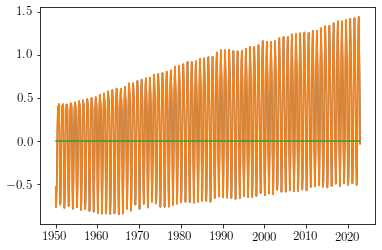

In [26]:
sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data'
w = xr.open_dataset(f'{sdir}/cflx_SECT_1950_2022_mask_band_ts_mean.nc')
wf = xr.open_dataset(f'{sdir}/cflx_SECT_1950_2022_mask_band_ts.nc')
w4 = xr.open_dataset(f'{sdir}/cflx_SECT_1950_2022_mask_42_ts_mean.nc')
wf4 = xr.open_dataset(f'{sdir}/cflx_SECT_1950_2022_mask_42_ts.nc')

plt.figure()
plt.plot(w.time_counter, w.Cflx * 47737042946685 * 3.156e7*12e-15)
plt.plot(wf.time_counter, wf.Cflx)
plt.plot(w.time_counter, w.Cflx * 47737042946685 * 3.156e7*12e-15 - wf.Cflx)

w = w.rename_vars({"Cflx": "Cflx_mask_band_mol/m2/s"})
w4 = w4.rename_vars({"Cflx": "Cflx_mask_42_mol/m2/s"})

wf = wf.rename_vars({"Cflx": "Cflx_mask_band_Pg/yr"})
wf4 = wf4.rename_vars({"Cflx": "Cflx_mask_42_Pg/yr"})


combined = xr.merge([w,wf,w4,wf4])
df = combined.to_dataframe()
df.to_csv('./ERA5_SECT_Cflx.csv')

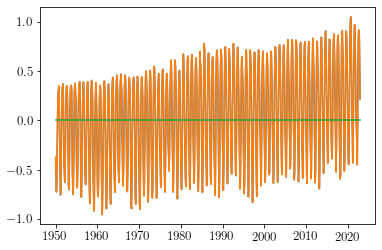

In [27]:
sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data'
w = xr.open_dataset(f'{sdir}/cflx_SNA0_1950_2022_mask_band_ts_mean.nc')
wf = xr.open_dataset(f'{sdir}/cflx_SNA0_1950_2022_mask_band_ts.nc')
w4 = xr.open_dataset(f'{sdir}/cflx_SNA0_1950_2022_mask_42_ts_mean.nc')
wf4 = xr.open_dataset(f'{sdir}/cflx_SNA0_1950_2022_mask_42_ts.nc')

plt.figure()
plt.plot(w.time_counter, w.Cflx * 47737042946685 * 3.156e7*12e-15)
plt.plot(wf.time_counter, wf.Cflx)
plt.plot(w.time_counter, w.Cflx * 47737042946685 * 3.156e7*12e-15 - wf.Cflx)

w = w.rename_vars({"Cflx": "Cflx_mask_band_mol/m2/s"})
w4 = w4.rename_vars({"Cflx": "Cflx_mask_42_mol/m2/s"})

wf = wf.rename_vars({"Cflx": "Cflx_mask_band_Pg/yr"})
wf4 = wf4.rename_vars({"Cflx": "Cflx_mask_42_Pg/yr"})


combined = xr.merge([w,wf,w4,wf4])
df = combined.to_dataframe()
df.to_csv('./NCEP_SNA0_Cflx.csv')

mb = 47737042946685.79


# plt.figure()
# plt.plot(w.time_counter, w.Cflx - w4.Cflx)
# #plt.plot(w4.time_counter, w4.Cflx)


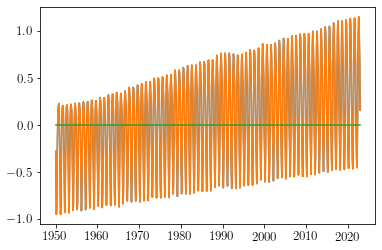

In [28]:
sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data'
w = xr.open_dataset(f'{sdir}/cflx_SNCT_1950_2022_mask_band_ts_mean.nc')
wf = xr.open_dataset(f'{sdir}/cflx_SNCT_1950_2022_mask_band_ts.nc')
w4 = xr.open_dataset(f'{sdir}/cflx_SNCT_1950_2022_mask_42_ts_mean.nc')
wf4 = xr.open_dataset(f'{sdir}/cflx_SNCT_1950_2022_mask_42_ts.nc')

plt.figure()
plt.plot(w.time_counter, w.Cflx * 47737042946685 * 3.156e7*12e-15)
plt.plot(wf.time_counter, wf.Cflx)
plt.plot(w.time_counter, w.Cflx * 47737042946685 * 3.156e7*12e-15 - wf.Cflx)

w = w.rename_vars({"Cflx": "Cflx_mask_band_mol/m2/s"})
w4 = w4.rename_vars({"Cflx": "Cflx_mask_42_mol/m2/s"})

wf = wf.rename_vars({"Cflx": "Cflx_mask_band_Pg/yr"})
wf4 = wf4.rename_vars({"Cflx": "Cflx_mask_42_Pg/yr"})


combined = xr.merge([w,wf,w4,wf4])
df = combined.to_dataframe()
df.to_csv('./NCEP_SNCT_Cflx.csv')

mb = 47737042946685.79


# plt.figure()
# plt.plot(w.time_counter, w.Cflx - w4.Cflx)
# #plt.plot(w4.time_counter, w4.Cflx)


In [8]:
qtrnewt_D = C14d_qtr_c14.qtrB14b.weighted(area).mean(dim = ['x','y'])
qtrnewt_D

NameError: name 'C14d_qtr_c14' is not defined

## put data in csv- ncep

In [ ]:
ex = False
if ex:
    sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data'
    Adir = 'SNA0'
    Cdir = 'SNCT'
    yrst = 1950
    yrend = 2022
    masknam = 'mask_42'
    qtrA = xr.open_dataset(f'{sdir}/qtr_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
    cflxA = xr.open_dataset(f'{sdir}/cflx_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
    qtrC = xr.open_dataset(f'{sdir}/qtr_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')
    cflxC = xr.open_dataset(f'{sdir}/cflx_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')

    qtrA_r = qtrA.rolling(time_counter=12, center=True).mean()
    cflxA_r = cflxA.rolling(time_counter=12, center=True).mean()
    qtrC_r = qtrC.rolling(time_counter=12, center=True).mean()
    cflxC_r = cflxC.rolling(time_counter=12, center=True).mean()

    times = pd.date_range(f'{yrst}/01/01',f'{yrend}/12/31',freq='MS')
    qtrA_v = qtrA.qtrB14b.values
    qtrA_rv = qtrA_r.qtrB14b.values
    qtrC_v = qtrC.qtrB14b.values
    qtrC_rv = qtrC_r.qtrB14b.values
    cflxA_v = cflxA.Cflx.values
    cflxA_rv = cflxA_r.Cflx.values
    cflxC_v = cflxC.Cflx.values
    cflxC_rv = cflxC_r.Cflx.values

    data = {
        'time': times,
        'qtrA': qtrA_v,
        'qtrA_roling': qtrA_rv,
        'qtrC': qtrC_v,
        'qtrC_roling': qtrC_rv,
        'cflxA': cflxA_v,
        'cflxA_roling': cflxA_rv,
        'cflxC': cflxC_v,
        'cflxC_roling': cflxC_rv,
    }


    # Create the DataFrame
    df = pd.DataFrame(data)

    # Display the DataFrame
    print(df)

    df.to_csv('./NCEP_qtr_and_cflx_mask42.csv')

## put data in csv- era5

In [ ]:
ex = False
if ex:
    sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data'
    Adir = 'SEA0'
    Cdir = 'SECT'
    yrst = 1950
    yrend = 2022
    masknam = 'mask_band'
    qtrA = xr.open_dataset(f'{sdir}/qtr_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
    cflxA = xr.open_dataset(f'{sdir}/cflx_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
    qtrC = xr.open_dataset(f'{sdir}/qtr_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')
    cflxC = xr.open_dataset(f'{sdir}/cflx_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')

    qtrA_r = qtrA.rolling(time_counter=12, center=True).mean()
    cflxA_r = cflxA.rolling(time_counter=12, center=True).mean()
    qtrC_r = qtrC.rolling(time_counter=12, center=True).mean()
    cflxC_r = cflxC.rolling(time_counter=12, center=True).mean()

    times = pd.date_range(f'{yrst}/01/01',f'{yrend}/12/31',freq='MS')
    qtrA_v = qtrA.qtrB14b.values
    qtrA_rv = qtrA_r.qtrB14b.values
    qtrC_v = qtrC.qtrB14b.values
    qtrC_rv = qtrC_r.qtrB14b.values
    cflxA_v = cflxA.Cflx.values
    cflxA_rv = cflxA_r.Cflx.values
    cflxC_v = cflxC.Cflx.values
    cflxC_rv = cflxC_r.Cflx.values

    data = {
        'time': times,
        'qtrA': qtrA_v,
        'qtrA_roling': qtrA_rv,
        'qtrC': qtrC_v,
        'qtrC_roling': qtrC_rv,
        'cflxA': cflxA_v,
        'cflxA_roling': cflxA_rv,
        'cflxC': cflxC_v,
        'cflxC_roling': cflxC_rv,
    }


    # Create the DataFrame
    df = pd.DataFrame(data)

    # Display the DataFrame
    print(df)

    df.to_csv('./ERA_qtr_and_cflx_mask42.csv')

## prepare data for plotting - normalized 
    this one doesn't work

In [ ]:
def get_for_plotting_norm(Adir,Cdir,dtn,masknam = 'mask_42'):

    print(masknam)
    sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data'
    
    yrst = 1950; yrend = 2022; #ts
    ysp = 1950; yep = 2017
    #
    qtrA = xr.open_dataset(f'{sdir}/qtr_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
    cflxA = xr.open_dataset(f'{sdir}/cflx_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
    qtrC = xr.open_dataset(f'{sdir}/qtr_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')
    cflxC = xr.open_dataset(f'{sdir}/cflx_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')

    qtrA_r = qtrA.rolling(time_counter=12, center=True).mean()
    cflxA_r = cflxA.rolling(time_counter=12, center=True).mean()
    qtrC_r = qtrC.rolling(time_counter=12, center=True).mean()
    cflxC_r = cflxC.rolling(time_counter=12, center=True).mean()

    times = pd.date_range(f'{ysp}/01/01',f'{yep}/12/31',freq='MS')


    qtrdiff = ((qtrA_r.qtrB14b-qtrC_r.qtrB14b)*-1).sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
    flxdiff = (cflxA_r.Cflx-cflxC_r.Cflx).sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
    flag = '---'
    r_value, p_value = pearsonr(qtrdiff, flxdiff)
    if r_value > 0.5:
        flag = '-★-'
    print(f'{flag}-{Adir}-{Cdir} (loopyr {yrs[c]} (not normalized) ({ysp}-{yep}) r: {r_value}, {p_value}')      

    print(d)
    w0 = xr.open_dataset(f'{tdir}{Cdir}_1948_2019_d{0}_C14B_{masknam}.nc')
    w1 = xr.open_dataset(f'{tdir}{Cdir}_1948_2019_d{d}_C14B_{masknam}.nc')
    wd = w0 - w1
    wd['time_counter'] = times
    wd_r = wd.rolling(time_counter=12, center=True).mean().sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))

    ## deal with crossing the zero
    if (np.nanmin(wd_r.C14B) < 0):
        print('crossed the 0!')
        wdn = wd_r - 2*np.nanmin(wd_r.C14B)
        wdn = wdn.C14B.values
        norm = qtrdiff.values/wdn

    else:
        wdn = wd_r.C14B.values
        norm = (qtrdiff.values/(wdn))            

    r_value, p_value = pearsonr(norm, flxdiff)
    if r_value > 0.5:
        flag = '-★-'
    print(f'{flag}-{Adir}-{Cdir} (dpthl {d}) ({ysp}-{yep})------------------- r: {r_value}, {p_value}')    

    return flxdiff, qtrdiff, norm

## prepare for plotting - not norm

    gives you basically rolling mean, also correlation

In [ ]:
def get_for_plotting(Adir,Cdir,dtn,masknam = 'mask_42', loopyear = 1967):

    print(masknam)
    
    yrst = 1950; yrend = 2022; #ts
    ysp = 1959; yep = 2015
    
    sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data'
    #
    qtrA = xr.open_dataset(f'{sdir}/qtr_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
    cflxA = xr.open_dataset(f'{sdir}/cflx_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
    qtrC = xr.open_dataset(f'{sdir}/qtr_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')
    cflxC = xr.open_dataset(f'{sdir}/cflx_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')

    qtrA_r = qtrA.rolling(time_counter=12, center=True).mean()
    cflxA_r = cflxA.rolling(time_counter=12, center=True).mean()
    qtrC_r = qtrC.rolling(time_counter=12, center=True).mean()
    cflxC_r = cflxC.rolling(time_counter=12, center=True).mean()

    times = pd.date_range(f'{ysp}/01/01',f'{yep}/12/31',freq='MS')

    qtrdiff = ((qtrA_r.qtrB14b-qtrC_r.qtrB14b)*-1).sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
    flxdiff = (cflxA_r.Cflx-cflxC_r.Cflx).sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))

    r_value, p_value = pearsonr(qtrdiff, flxdiff)

    return flxdiff, qtrdiff, r_value, p_value

## load and plot obs

In [ ]:
# Specify the path to your Excel file
file_path = './obs/Campbell_Is_vs_Tasmania_gradient_data_Corinne.xlsx'
# Read the Excel file, skipping the first row
df = pd.read_excel(file_path, skiprows=1)

df.rename(columns={'Year (centred on year of growth e.g. 1952 represents October 1951 to March 1952)': 'yr'}, inplace=True)
df.rename(columns={'Delta14C difference': 'Dc14diff'}, inplace=True)

print(df.yr)
time = pd.date_range(start=f"{1950}-01-01", end=f"{2013}-12-31", freq='YS')

#Create a NumPy array of random floats with the same length as the time dimension
data = df.Dc14diff
# Create the DataArray
obs_wyxr = xr.DataArray(
    data=data,
    coords={"time": time},
    dims=["time"],
)


# Create the date range
#date_range = pd.date_range(start=f'{1950}-07-01', periods=num_years, freq='AS-JUL')
date_range = pd.date_range(start=f"{1950}-01-01", end=f"{2013}-12-31", freq='AS-JAN')
plt.plot(obs_wyxr.time,obs_wyxr.data, 'yo-')
plt.axhline(y= 0)
plt.grid()
plt.title('observational $\Delta$C14, Campbell Is (52S) - Tasmania (40S)')




In [ ]:
# Specify the path to your Excel file
file_path = './obs/Campbell_Is_vs_Tasmania_gradient_data_Corinne.xlsx'

# Read the Excel file, skipping the first row
df = pd.read_excel(file_path, skiprows=1)

df.rename(columns={'Year (centred on year of growth e.g. 1952 represents October 1951 to March 1952)': 'yr'}, inplace=True)
df.rename(columns={'Delta14C difference': 'Dc14diff'}, inplace=True)


## plot map of where the obs are

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define coordinates
tasmania_coords = (-41.8961, 145.5292)  # Tasmania: 41°53’46” S, 145°31’45” E in decimal degrees
campbell_coords = (-52.59, 169.17)  # Campbell Island: 52.59°S, 169.17°E

# Define extent (10 degrees perimeter around points)
min_lat = min(tasmania_coords[0], campbell_coords[0]) - 10
max_lat = max(tasmania_coords[0], campbell_coords[0]) + 10
min_lon = min(tasmania_coords[1], campbell_coords[1]) - 10
max_lon = max(tasmania_coords[1], campbell_coords[1]) + 10

# Create the map
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.add_feature(cfeature.RIVERS)

# Plot the points
ax.plot(tasmania_coords[1], tasmania_coords[0], 'ro', label='Tasmania')
ax.plot(campbell_coords[1], campbell_coords[0], 'bo', label='Campbell Island')

# Add legend and gridlines
ax.legend(loc='lower left')
ax.gridlines(draw_labels=True)

# Title and display the map
plt.title("Map Showing Tasmania and Campbell Island")
plt.show()

## plot best available

In [ ]:
yrst = 1950; yrend = 2022; #ts
ysp = 1959; yep = 2015
    
Adir = 'SEA0'; Cdir = 'SECT'; masknam = 'mask_42'; loopyear = 1967
sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data'

qtrA = xr.open_dataset(f'{sdir}/qtr_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
cflxA = xr.open_dataset(f'{sdir}/cflx_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
qtrC = xr.open_dataset(f'{sdir}/qtr_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')
cflxC = xr.open_dataset(f'{sdir}/cflx_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')

qtrA_r = qtrA.rolling(time_counter=12, center=True).mean()
cflxA_r = cflxA.rolling(time_counter=12, center=True).mean()
qtrC_r = qtrC.rolling(time_counter=12, center=True).mean()
cflxC_r = cflxC.rolling(time_counter=12, center=True).mean()

times = pd.date_range(f'{ysp}/01/01',f'{yep}/12/31',freq='MS')

fact = 0.5
fig, axs = plt.subplots(2,2, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(cflxA_r.time_counter,cflxA_r.Cflx, color = 'r', label = 'A run (clim var)')
axs[0].plot(cflxA_r.time_counter,cflxC_r.Cflx, color = 'g', label = 'C run (clim looping)')
axs[2].plot(cflxA_r.time_counter,qtrA_r.qtrB14b, color = 'r', label = 'A run')
axs[2].plot(cflxA_r.time_counter,qtrC_r.qtrB14b, color = 'g', label = 'C run')



qtrA = xr.open_dataset(f'{sdir}/qtr_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
cflxA = xr.open_dataset(f'{sdir}/cflx_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
qtrC = xr.open_dataset(f'{sdir}/qtr_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')
cflxC = xr.open_dataset(f'{sdir}/cflx_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')

qtrA_r = qtrA.rolling(time_counter=12, center=True).mean()
cflxA_r = cflxA.rolling(time_counter=12, center=True).mean()
qtrC_r = qtrC.rolling(time_counter=12, center=True).mean()
cflxC_r = cflxC.rolling(time_counter=12, center=True).mean()

axs[1].plot(cflxA_r.time_counter,cflxA_r.Cflx, color = 'r', label = 'A run')
axs[1].plot(cflxA_r.time_counter,cflxC_r.Cflx, color = 'g', label = 'C run')
axs[3].plot(cflxA_r.time_counter,qtrA_r.qtrB14b, color = 'r', label = 'A run')
axs[3].plot(cflxA_r.time_counter,qtrC_r.qtrB14b, color = 'g', label = 'C run')

axs[0].legend(loc = 'best')

axs[0].set_title('Cflx, SEA0/SECT (ERA5 forcing)')
axs[1].set_title('Cflx, SNA0/SNCT (NCEP forcing)')       
axs[2].set_title('bomb C14 flux, (ERA5 forcing)')
axs[3].set_title('bomb C14 flux, (NCEP forcing)') 

for i in range(0,4):
    axs[i].grid()
plt.tight_layout()

In [ ]:
SECT_flxdiff, SECT_qtrdiff, r_valueE, p_value = get_for_plotting('SEA0','SECT',24, masknam = 'mask_42')
SNCT_flxdiff, SNCT_qtrdiff, r_valueN, p_value = get_for_plotting('SNA0','SNCT',20, masknam = 'mask_42')

fact = 0.5
fig, axs = plt.subplots(2,1, figsize=(14*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(SECT_flxdiff.time_counter,SECT_flxdiff, color = 'r', label = 'A-C Cflx')
axs[0].axhline(y=0, color = 'r')
axs0b = axs[0].twinx()
axs0b.plot(SECT_flxdiff.time_counter,(SECT_qtrdiff), color = 'k', label = 'A-C c14')

axs[1].plot(SNCT_flxdiff.time_counter,(SNCT_flxdiff), color = 'r', label = 'A-C Cflx')
axs[1].axhline(y=0, color = 'r')
axs1b = axs[1].twinx()
axs1b.plot(SNCT_flxdiff.time_counter,(SNCT_qtrdiff), color = 'k', label = 'A-C c14')

# axs0b.plot(date_range,df.Dc14diff/np.min(df.Dc14diff), 'yo-')
# axs1b.plot(date_range,df.Dc14diff/np.min(df.Dc14diff), 'yo-')

axs[0].set_ylabel('Cflx difference A-C (red)', color = 'r')
axs0b.set_ylabel('bomb C14 flux difference C-A (black)')
axs[1].set_ylabel('Cflx difference A-C (red)', color = 'r')
axs1b.set_ylabel('bomb C14 flux difference C-A (black)')

axs[0].set_title(f'ERA5 forcing, looping year 1967, Pearson r: {round(r_valueE,3)}')
axs[1].set_title(f'NCEP forcing, looping year 1967 Pearson r: {round(r_valueN,3)}')
plt.tight_layout()

## data addition

note that this is an odd normalization:

    (model bomb C14 flux)/ max(model bomb C14 flux)
    (obs bomb C14 flux)/ min (obs bomb C14 flux), which flips the signal

In [ ]:
SECT_flxdiff, SECT_qtrdiff, r_valueE, p_value = get_for_plotting('SEA0','SECT',24)
SNCT_flxdiff, SNCT_qtrdiff, r_valueN, p_value = get_for_plotting('SNA0','SNCT',20)

fact = 0.6
fig, axs = plt.subplots(2,1, figsize=(14*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(SECT_flxdiff.time_counter,SECT_flxdiff, color = 'r', label = 'A-C Cflx')
axs0b = axs[0].twinx()
axs0b.plot(SECT_flxdiff.time_counter,(SECT_qtrdiff/np.max(SECT_qtrdiff)), color = 'k', label = 'A-C c14')

axs[1].plot(SNCT_flxdiff.time_counter,(SNCT_flxdiff), color = 'r', label = 'A-C Cflx')
axs1b = axs[1].twinx()
axs1b.plot(SNCT_flxdiff.time_counter,(SNCT_qtrdiff/np.max(SNCT_qtrdiff)), color = 'k', label = 'A-C c14')

axs0b.plot(date_range,df.Dc14diff/np.min(df.Dc14diff), 'yo-')
axs1b.plot(date_range,df.Dc14diff/np.min(df.Dc14diff), 'yo-')

axs[0].set_ylabel('Cflx difference A-C (red)', color = 'r')
axs0b.set_ylabel('bomb C14 flux difference A-C (black)')
axs[1].set_ylabel('Cflx difference A-C (red)', color = 'r')
axs1b.set_ylabel('bomb C14 flux difference A-C (black)')

axs[0].set_title(f'ERA5 forcing, looping year 1967, Pearson r: {round(r_valueE,3)}')
axs[1].set_title(f'NCEP forcing, looping year 1967 Pearson r: {round(r_valueN,3)}')


plt.tight_layout()



## get yearly-average data from model

a year is (oct nov dec)[yr-1] -- (jan feb mar)[yr]

In [ ]:
yrst = 1950; yrend = 2022; #ts
ysp = 1959; yep = 2015
    

Adir = 'SEA0'; Cdir = 'SECT'; masknam = 'mask_42'; loopyear = 1967

def get_yearlyavg_data(Adir, Cdir, masknam = 'mask_42'):
    
    sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data'

    qtrA = xr.open_dataset(f'{sdir}/qtr_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
    cflxA = xr.open_dataset(f'{sdir}/cflx_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
    qtrC = xr.open_dataset(f'{sdir}/qtr_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')
    cflxC = xr.open_dataset(f'{sdir}/cflx_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')

    qtrA_fy = np.zeros_like(np.arange(1959,2016)).astype(float)
    qtrC_fy = np.zeros_like(np.arange(1959,2016)).astype(float)
    cflxA_fy = np.zeros_like(np.arange(1959,2016)).astype(float)
    cflxC_fy = np.zeros_like(np.arange(1959,2016)).astype(float)

    for yr in range(1959,2015):

        qtrA_fy[yr-1959] = qtrA.qtrB14b.sel(time_counter=slice(f'{yr-1}-10-01', f'{yr}-03-31')).mean()
        qtrC_fy[yr-1959] = qtrC.qtrB14b.sel(time_counter=slice(f'{yr-1}-10-01', f'{yr}-03-31')).mean()
        cflxA_fy[yr-1959] = cflxA.Cflx.sel(time_counter=slice(f'{yr-1}-10-01', f'{yr}-03-31')).mean()
        cflxC_fy[yr-1959] = cflxC.Cflx.sel(time_counter=slice(f'{yr-1}-10-01', f'{yr}-03-31')).mean()

        
    qtrdiff = ((qtrA_fy-qtrC_fy)*-1)
    flxdiff = (cflxA_fy-cflxC_fy)

    r_value, p_value = pearsonr(qtrdiff, flxdiff)

    return flxdiff, qtrdiff, r_value, p_value

## plot yearly-avg data

In [ ]:
SECT_flxdiff, SECT_qtrdiff, r_valueE, p_value = get_yearlyavg_data('SEA0','SECT')
SNCT_flxdiff, SNCT_qtrdiff, r_valueN, p_value = get_yearlyavg_data('SNA0','SNCT')

times = pd.date_range(f"1959/01/01",f"2016/01/01",freq='YS',closed='left')

fact = 0.6
fig, axs = plt.subplots(2,1, figsize=(14*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(times,SECT_flxdiff, color = 'r', label = 'A-C Cflx')
axs0b = axs[0].twinx()
axs0b.plot(times,(SECT_qtrdiff/np.max(SECT_qtrdiff)), color = 'k', label = 'A-C c14')

axs[1].plot(times,(SNCT_flxdiff), color = 'r', label = 'A-C Cflx')
axs1b = axs[1].twinx()
axs1b.plot(times,(SNCT_qtrdiff/np.max(SNCT_qtrdiff)), color = 'k', label = 'A-C c14')

# axs0b.plot(date_range,df.Dc14diff/np.min(df.Dc14diff), 'yo-')
# axs1b.plot(date_range,df.Dc14diff/np.min(df.Dc14diff), 'yo-')

axs[0].set_ylabel('Cflx difference A-C (red)', color = 'r')
axs0b.set_ylabel('bomb C14 flux difference A-C (black)')
axs[1].set_ylabel('Cflx difference A-C (red)', color = 'r')
axs1b.set_ylabel('bomb C14 flux difference A-C (black)')

axs[0].set_title(f'ERA5 forcing, looping year 1967, Pearson r: {round(r_valueE,3)}')
axs[1].set_title(f'NCEP forcing, looping year 1967 Pearson r: {round(r_valueN,3)}')
plt.tight_layout()



## bomb radiocarbon from model vs bomb radiocarbon vs obs

In [ ]:
SECT_flxdiff, SECT_qtrdiff, r_valueE, p_value = get_yearlyavg_data('SEA0','SECT')
SNCT_flxdiff, SNCT_qtrdiff, r_valueN, p_value = get_yearlyavg_data('SNA0','SNCT')

times = pd.date_range(f"1959/01/01",f"2016/01/01",freq='YS',closed='left')

fact = 0.6
fig, axs = plt.subplots(2,1, figsize=(14*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(date_range,df.Dc14diff, 'yo-')
axs0b = axs[0].twinx()
axs0b.plot(times,SECT_qtrdiff, color = 'k', label = 'C-A c14')

axs[1].plot(date_range,df.Dc14diff, 'yo-')
axs1b = axs[1].twinx()
axs1b.plot(times,SNCT_qtrdiff, color = 'k', label = 'C-A c14')

axs[0].set_ylabel('obs C14 diff campbell- tasmania', color = 'y')
axs0b.set_ylabel('bomb C14 flux difference C-A (black)')
axs[1].set_ylabel('obs C14 diff campbell- tasmania', color = 'y')
axs1b.set_ylabel('bomb C14 flux difference C-A (black)')

axs[0].set_title('bomb C14 flux, model and obs, ERA5')
axs[1].set_title('bomb C14 flux, model and obs, NCEP')

for i in range(0,2):
    axs[i].grid()

In [ ]:
start_year = 1959
end_year = 2015
time = pd.date_range(start=f"{start_year}-01-01", end=f"{end_year}-12-31", freq='YS')

# Create a NumPy array of random floats with the same length as the time dimension
data = SECT_qtrdiff
# Create the DataArray
ERA_bomb14 = xr.DataArray(
    data=data,
    coords={"time": time},
    dims=["time"],
)

data = SNCT_qtrdiff
# Create the DataArray
NCEP_bomb14 = xr.DataArray(
    data=data,
    coords={"time": time},
    dims=["time"],
)

start_year = 1950
end_year = 2013
time = pd.date_range(start=f"{start_year}-01-01", end=f"{end_year}-12-31", freq='YS')

# Create a NumPy array of random floats with the same length as the time dimension
data = df.Dc14diff
# Create the DataArray
obs_bomb14 = xr.DataArray(
    data=data,
    coords={"time": time},
    dims=["time"],
)



In [ ]:
def get_corr(ys, ye, c14, wind, verbose = False):
    
    c14d = c14.sel(time=slice(f'{ys}-01-01', f'{ye}-12-31')).values #invert obs
    windd = wind.sel(time=slice(f'{ys}-01-01', f'{ye}-12-31')).values 
    
    r_value, p_value = pearsonr(c14d, windd)
    if verbose:
        print(f'{ys}-{ye}: r {r_value} p {p_value}')
        
    return r_value, p_value

c14 = obs_bomb14
wind = NCEP_bomb14
rmin = 0.1
print('obs v mod (NCEP)')
for ys in range(1968,1979):
    for ye in range(2004,2013):
        r_value, p_value = get_corr(ys, ye, c14, wind, False)
        if r_value > rmin:
            print(f'{ys}-{ye}: r {r_value} p {p_value}')
            
c14 = obs_bomb14
wind = ERA_bomb14
rmin = 0.1
print('obs v mod (ERA)')
for ys in range(1968,1979):
    for ye in range(2004,2013):
        r_value, p_value = get_corr(ys, ye, c14, wind, False)
        if r_value > rmin:
            print(f'{ys}-{ye}: r {r_value} p {p_value}')

In [ ]:
SECT_flxdiff, SECT_qtrdiff, r_valueE, p_value = get_for_plotting('SEA0','SECT',24)
SNCT_flxdiff, SNCT_qtrdiff, r_valueN, p_value = get_for_plotting('SNA0','SNCT',20)
add = False
fact = 0.6
fig, axs = plt.subplots(2,2, figsize=(24*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(SECT_flxdiff.time_counter,SECT_flxdiff, color = 'r', label = 'A-C Cflx')
axs0b = axs[0].twinx()
axs0b.plot(SECT_flxdiff.time_counter,(SECT_qtrdiff/np.max(SECT_qtrdiff)), color = 'k', label = 'A-C c14')

axs[2].plot(SNCT_flxdiff.time_counter,(SNCT_flxdiff), color = 'r', label = 'A-C Cflx')
axs1b = axs[2].twinx()
axs1b.plot(SNCT_flxdiff.time_counter,(SNCT_qtrdiff/np.max(SNCT_qtrdiff)), color = 'k', label = 'A-C c14')

if add:
    axs0b.plot(date_range,df.Dc14diff/np.max(df.Dc14diff), 'yo-')
    axs1b.plot(date_range,df.Dc14diff/np.max(df.Dc14diff), 'yo-')
    
axs[0].set_ylabel('Cflx difference A-C (red)', color = 'r')
axs0b.set_ylabel('bomb C14 flux difference C-A (black)')
axs[2].set_ylabel('Cflx difference A-C (red)', color = 'r')
axs1b.set_ylabel('bomb C14 flux difference C-A (black)')

axs[0].set_title(f'ERA5 forcing, looping year 1967, Pearson r: {round(r_valueE,3)}')
axs[2].set_title(f'NCEP forcing, looping year 1967 Pearson r: {round(r_valueN,3)}')

##
times = pd.date_range(f"1959/01/01",f"2016/01/01",freq='YS',closed='left')

SECT_flxdiff, SECT_qtrdiff, r_valueE, p_value = get_yearlyavg_data('SEA0','SECT')
SNCT_flxdiff, SNCT_qtrdiff, r_valueN, p_value = get_yearlyavg_data('SNA0','SNCT')

axs[1].plot(times,SECT_flxdiff, color = 'r', label = 'A-C Cflx')
axs0b = axs[1].twinx()
axs0b.plot(times,(SECT_qtrdiff/np.max(SECT_qtrdiff)), color = 'k', label = 'A-C c14')

axs[3].plot(times,(SNCT_flxdiff), color = 'r', label = 'A-C Cflx')
axs1b = axs[3].twinx()
axs1b.plot(times,(SNCT_qtrdiff/np.max(SNCT_qtrdiff)), color = 'k', label = 'A-C c14')

# axs0b.plot(date_range,df.Dc14diff/np.min(df.Dc14diff), 'yo-')
# axs1b.plot(date_range,df.Dc14diff/np.min(df.Dc14diff), 'yo-')

axs[1].set_ylabel('Cflx difference A-C (red)', color = 'r')
axs0b.set_ylabel('bomb C14 flux difference C-A (black)')
axs[3].set_ylabel('Cflx difference A-C (red)', color = 'r')
axs1b.set_ylabel('bomb C14 flux difference C-A (black)')

axs[1].set_title(f'ERA5 forcing, looping year 1967, \n yearly data (Oct-Mar, year defined by Jan) Pearson r: {round(r_valueE,3)}')
axs[3].set_title(f'NCEP forcing, looping year 1967 \n yearly data (Oct-Mar, year defined by Jan) Pearson r: {round(r_valueN,3)}')

if add:
    axs0b.plot(date_range,df.Dc14diff/np.max(df.Dc14diff), 'yo-')
    axs1b.plot(date_range,df.Dc14diff/np.max(df.Dc14diff), 'yo-')

for i in range(0,4):
    axs[i].grid()
plt.tight_layout()



## get out data from the wind product (monthly, and also yearly-avg)

In [ ]:
import xarray as xr
savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
cdomask = xr.open_dataset(savenam)

cdomask.lat[37:49]
#tmask.isel(lat = slice(37,49)

In [ ]:
ex = False
if ex:
    
    def make_yearlist(yrst, yrend, prod, \
                     baseDir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/'):
        yrs = np.arange(yrst,yrend+1,1)
        ylist = []
        for i in range(0,len(yrs)):
            ty = f'{baseDir}/{prod}/{prod}_wind_daily_1x1_{yrs[i]}.nc'
            t2 = glob.glob(ty)
            #print(t2)
            ylist.append(t2[0])
        return ylist

    sdir = './CAL12_series_data/'

    savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
    cdomask = xr.open_dataset(savenam)
    cdomask
    tmask = cdomask.tmask

    erast = 1950; en = 2015
    era = xr.open_mfdataset(make_yearlist(erast, en, 'ERA5'))
    era_ts = era.wspd10m.sel(time_counter=slice(f'{erast}-01-01', f'{en+1}-01-01'))
    era_ts2 = era_ts.isel(lat = slice(37,49)).weighted(tmask.isel(lat = slice(37,49))).mean(dim = ['lat', 'lon'])
    era_ts2.attrs = {"made in": 'plottingCode/extract_ts.py'}
    era_ts2.to_netcdf(f'{sdir}/ERA5_mask_band_mean_wspd_ts.nc')
    print('done')

    era = xr.open_mfdataset(make_yearlist(erast, en, 'NCEP-NCAR'))
    era_ts = era.wspd10m.sel(time_counter=slice(f'{erast}-01-01', f'{en+1}-01-01'))
    era_ts2 = era_ts.isel(lat = slice(37,49)).weighted(tmask.isel(lat = slice(37,49))).mean(dim = ['lat', 'lon'])
    era_ts2.attrs = {"made in": 'plottingCode/extract_ts.py'}
    era_ts2.to_netcdf(f'{sdir}/NCEP-NCAR_mask_band_mean_wspd_ts.nc')
    print('done')

In [ ]:
era_w = xr.open_dataset(f'{sdir}/ERA5_mask_band_mean_wspd_ts.nc')
ncep_w = xr.open_dataset(f'{sdir}/NCEP-NCAR_mask_band_mean_wspd_ts.nc')

In [ ]:
era_wr = era_w.rolling(time_counter=12, center=True).mean()
ncep_wr = era_w.rolling(time_counter=12, center=True).mean()

ysp = 1959; yep = 2014
times = pd.date_range(f'{ysp}/01/01',f'{yep}/12/31',freq='YS')

era_wrs = era_wr.sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
ncep_wrs = ncep_wr.sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))

era_wy = np.zeros_like(np.arange(1959,2015)).astype(float)
ncep_wy = np.zeros_like(np.arange(1959,2015)).astype(float)
for yr in range(1959,2015):

    era_wy[yr-1959] = era_w.wspd10m.sel(time_counter=slice(f'{yr-1}-10-01', f'{yr}-03-31')).mean()
    ncep_wy[yr-1959] = ncep_w.wspd10m.sel(time_counter=slice(f'{yr-1}-10-01', f'{yr}-03-31')).mean()


### plot monthly data

In [ ]:
fact = 0.6
fig, axs = plt.subplots(2,2, figsize=(24*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

#axs[0].plot(era_w.time_counter, era_w.wspd10m, color = 'r')
era_1967_wya = era_wrs.wspd10m.sel(time_counter=slice(f'1966-10-01', f'1967-03-31')).mean()
era_1967_wrsa = era_wrs.wspd10m.sel(time_counter=slice(f'1967-01-01', f'1967-12-31')).mean()
era_1967_wy = np.zeros_like(era_wy); era_1967_wy[:] = era_1967_wya
era_1967_wrs = np.zeros_like(era_wrs.wspd10m); era_1967_wrs[:] = era_1967_wrsa

ncep_1967_wya = ncep_wrs.wspd10m.sel(time_counter=slice(f'1966-10-01', f'1967-03-31')).mean()
ncep_1967_wrsa = ncep_wrs.wspd10m.sel(time_counter=slice(f'1967-01-01', f'1967-12-31')).mean()
ncep_1967_wy = np.zeros_like(ncep_wy); ncep_1967_wy[:] = ncep_1967_wya
ncep_1967_wrs = np.zeros_like(ncep_wrs.wspd10m); ncep_1967_wrs[:] = ncep_1967_wrsa

from scipy.signal import detrend
ncep_wydt = detrend(ncep_wy)
era_wydt = detrend(era_wy)

axs[0].plot(era_wrs.time_counter, era_wrs.wspd10m, color = 'b')
axs[0].plot(era_wrs.time_counter, era_1967_wrs, color = 'k', label = 'fy mean 1967')
axs[1].plot(times, era_wy, color = 'b')
#axs[1].plot(times, era_wydt, color = 'b', linestyle = ':')
axs[1].plot(times, era_1967_wy, color = 'k', label = 'growing season mean 1967')

axs[2].plot(ncep_wrs.time_counter, ncep_wrs.wspd10m, color = 'b')
axs[2].plot(ncep_wrs.time_counter, ncep_1967_wrs, color = 'k', label = 'fy mean 1967')
axs[3].plot(times, ncep_wy, color = 'b')
#axs[3].plot(times, ncep_wydt, color = 'b', linestyle = ':')
axs[3].plot(times, ncep_1967_wy, color = 'k', label = 'growing season mean 1967')

axs[0].set_title('ERA5 winds (42-52S)  \n monthly, 12-month run filt')
axs[2].set_title('NCEP winds (42-52S)  \n monthly, 12-month run filt')
axs[1].set_title('ERA5 winds (42-52S)  \n yearly, Oct-Mar mean, year def by Jan')
axs[3].set_title('NCEP winds (42-52S)  \n yearly, Oct-Mar mean, year def by Jan')

for i in range(0,4):
    axs[i].set_ylabel('m/s')
    axs[i].grid()
    
plt.suptitle('black line is mean of year 1967, calc. the respective ways')
plt.tight_layout()

## store yrly era and ncep as xarray, plot along with c14 obs

In [ ]:
start_year = 1959
end_year = 2014
time = pd.date_range(start=f"{start_year}-01-01", end=f"{end_year}-12-31", freq='YS')

# Create a NumPy array of random floats with the same length as the time dimension
data = ncep_wy
# Create the DataArray
ncep_wyxr = xr.DataArray(
    data=data,
    coords={"time": time},
    dims=["time"],
)
# Create a NumPy array of random floats with the same length as the time dimension
data = era_wy
# Create the DataArray
era_wyxr = xr.DataArray(
    data=data,
    coords={"time": time},
    dims=["time"],
)

data = ncep_wydt
# Create the DataArray
ncep_wydtxr = xr.DataArray(
    data=data,
    coords={"time": time},
    dims=["time"],
)
# Create a NumPy array of random floats with the same length as the time dimension
data = era_wydt
# Create the DataArray
era_wydtxr = xr.DataArray(
    data=data,
    coords={"time": time},
    dims=["time"],
)
#obs_wyxr

In [ ]:
fact = 0.6
fig, axs = plt.subplots(2,1, figsize=(14*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(ncep_wyxr.time,ncep_wyxr.data,'r-', label = 'ncep winds')
axs[0].plot(ncep_wyxr.time,era_wyxr.data,'b-', label = 'era5 winds')
axs0b = axs[0].twinx()
axs0b.plot(obs_wyxr.time,obs_wyxr.data*-1,'y-', label = 'observational C14 diff * -1')

axs[0].set_title('winds and inverted observational c14 signal \n (in original signal, negative anomalies mean stronger winds, \n here positive anomalies mean stronger winds')
axs0b.legend(loc = 'lower right')
axs[0].legend()

#
axs[1].plot(ncep_wyxr.time,ncep_wydtxr.data,'r-', label = 'ncep winds detrended')
axs[1].plot(ncep_wyxr.time,era_wydtxr.data,'b-', label = 'era5 winds detrended')
axs0b = axs[1].twinx()
axs0b.plot(obs_wyxr.time,obs_wyxr.data*-1,'y-', label = 'observational C14 diff * -1')

axs[1].set_title('detrended winds and inverted observational c14 signal \n (in original signal, negative anomalies mean stronger winds, \n here positive anomalies mean stronger winds')
axs0b.legend(loc = 'lower right')
axs[1].legend()

for i in range(0,2):
    axs[i].set_ylabel('m/s')
    axs[i].grid()

plt.tight_layout()

### get correlations 

In [ ]:
# Define the ranges for startyear and endyear
startyear = np.arange(1968, 1979)  # 1968 to 1978 inclusive
endyear = np.arange(2004, 2015)   # 2004 to 2014 inclusive

# Create a 2D array of random floats with dimensions (startyear, endyear)
data = np.random.random((len(startyear), len(endyear)))

# Initialize the DataArray
corr_obs_ncepdt = xr.DataArray(
    data=data,
    coords={"startyear": startyear, "endyear": endyear},
    dims=["startyear", "endyear"],
    name="example_data"
)

corr_obs_eradt = xr.DataArray(
    data=data,
    coords={"startyear": startyear, "endyear": endyear},
    dims=["startyear", "endyear"],
    name="example_data"
)

In [ ]:
def get_corr(ys, ye, c14, wind, verbose = False):
    
    c14d = c14.sel(time=slice(f'{ys}-01-01', f'{ye}-12-31')).values  * -1 #invert obs
    windd = wind.sel(time=slice(f'{ys}-01-01', f'{ye}-12-31')).values 
    
    r_value, p_value = pearsonr(c14d, windd)
    if verbose:
        print(f'{ys}-{ye}: r {r_value} p {p_value}')
        
    return r_value, p_value

c14 = obs_wyxr
wind = ncep_wydtxr
rmin = 0.1
print('NCEP')
for ys in range(1968,1979):
    for ye in range(2004,2014):
        r_value, p_value = get_corr(ys, ye, c14, wind, False)
        if r_value > rmin:
            print(f'{ys}-{ye}: r {r_value} p {p_value}')
            
c14 = obs_wyxr
wind = era_wydtxr
rmin = 0.3
print('ERA')
for ys in range(1968,1979):
    for ye in range(2004,2014):
        r_value, p_value = get_corr(ys, ye, c14, wind, False)
        if r_value > rmin:
            print(f'{ys}-{ye}: r {r_value} p {p_value}')

## put b14 into stuff

In [ ]:
tdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data/'

p = 'SECT'
#plt.figure()

# ds = [0,6,10,15,]#18,20,24]
# for d in ds:
#     w = xr.open_dataset(f'{tdir}/TOM12_TJ_{p}_d{d}_B14B_ts.nc')
#     times = pd.date_range(f'{1948}/01/01',f'{2022}/12/31',freq='MS')
#     #print(w.time_counter)
#     w['time_counter'] = times
#     #plt.plot(w.time_counter, w.B14B, label = d)
    
#     w = xr.open_dataset(f'{tdir}/TOM12_TJ_{p}_d{d}_C14B_ts.nc')
#     #times = pd.date_range(f'{1948}/01/01',f'{2022}/12/31',freq='MS')
#     #print(w.time_counter)
#     # w['time_counter'] = times
#     # plt.plot(w.time_counter, w.C14B, label = d)
    
fact = 0.6
fig, axs = plt.subplots(2,2, figsize=(18*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

d = 0; p = 'SECT'
w0 = xr.open_dataset(f'{tdir}/TOM12_TJ_{p}_d{d}_B14B_ts.nc')
times = pd.date_range(f'{1948}/01/01',f'{2022}/12/31',freq='MS')
w0['time_counter'] = times


ds = [0,6,10,15,18,20]#,24]
for d in ds:
    w = xr.open_dataset(f'{tdir}/TOM12_TJ_{p}_d{d}_B14B_ts.nc')
    times = pd.date_range(f'{1948}/01/01',f'{2022}/12/31',freq='MS')
    #print(w.time_counter)
    w['time_counter'] = times
    axs[0].plot(w.time_counter, w.B14B, label = f'd {d}')
    axs[1].plot(w.time_counter, w0.B14B - w.B14B, label = f'surface - d {d}')


axs[0].legend(ncol = 2, fontsize = 10)
axs[1].legend(bbox_to_anchor = [1,1])


d = 0; p = 'SNCT'
w0 = xr.open_dataset(f'{tdir}/TOM12_TJ_{p}_d{d}_B14B_ts.nc')
times = pd.date_range(f'{1950}/01/01',f'{2022}/12/31',freq='MS')
w0['time_counter'] = times


ds = [0,6,10,15,18,20]#,24]
for d in ds:
    w = xr.open_dataset(f'{tdir}/TOM12_TJ_{p}_d{d}_B14B_ts.nc')
    times = pd.date_range(f'{1950}/01/01',f'{2022}/12/31',freq='MS')
    #print(w.time_counter)
    w['time_counter'] = times
    axs[2].plot(w.time_counter, w.B14B, label = f'd {d}')
    axs[3].plot(w.time_counter, w0.B14B - w.B14B, label = f'surface - d {d}')


axs[2].legend(ncol = 2, fontsize = 10)
axs[3].legend(bbox_to_anchor = [1,1])

tits = ['B14 at depth \n ERA C run, SECT',' B14 at surf-depth \n ERA C run, SECT',\
        'B14 at depth \n NCEP C run, SNCT',' B14 at surf-depth \n NCEP C run, SNCT']#,\
        
    
for i in range(0,4):
    axs[i].set_title(tits[i])
    
plt.tight_layout()

In [ ]:
p = 'SECT'

w0 = xr.open_dataset(f'{tdir}/TOM12_TJ_{p}_d0_B14B_ts.nc')
times = pd.date_range(f'{1948}/01/01',f'{2022}/12/31',freq='MS')
w0['time_counter'] = times
w0 = w0.sel(time_counter=slice(f'{1950}-01-01', f'{2022}-12-31'))
times2 = pd.date_range(f'{1950}/01/01',f'{2022}/12/31',freq='MS')
    
w6 = xr.open_dataset(f'{tdir}/TOM12_TJ_{p}_d6_B14B_ts.nc')
times = pd.date_range(f'{1948}/01/01',f'{2022}/12/31',freq='MS')
w6['time_counter'] = times
w6 = w6.sel(time_counter=slice(f'{1950}-01-01', f'{2022}-12-31'))

w10 = xr.open_dataset(f'{tdir}/TOM12_TJ_{p}_d10_B14B_ts.nc')
times = pd.date_range(f'{1948}/01/01',f'{2022}/12/31',freq='MS')
w10['time_counter'] = times
w10 = w10.sel(time_counter=slice(f'{1950}-01-01', f'{2022}-12-31'))

w15 = xr.open_dataset(f'{tdir}/TOM12_TJ_{p}_d15_B14B_ts.nc')
times = pd.date_range(f'{1948}/01/01',f'{2022}/12/31',freq='MS')
w15['time_counter'] = times
w15 = w15.sel(time_counter=slice(f'{1950}-01-01', f'{2022}-12-31'))

w18 = xr.open_dataset(f'{tdir}/TOM12_TJ_{p}_d18_B14B_ts.nc')
times = pd.date_range(f'{1948}/01/01',f'{2022}/12/31',freq='MS')
w18['time_counter'] = times
w18 = w18.sel(time_counter=slice(f'{1950}-01-01', f'{2022}-12-31'))

w20 = xr.open_dataset(f'{tdir}/TOM12_TJ_{p}_d20_B14B_ts.nc')
times = pd.date_range(f'{1948}/01/01',f'{2022}/12/31',freq='MS')
w20['time_counter'] = times
w20 = w20.sel(time_counter=slice(f'{1950}-01-01', f'{2022}-12-31'))



data = {
    'time': times2,
    'B14_d0': w0.B14B.values,
    'B14_d0_rolling': w0.B14B.rolling(time_counter=12, center=True).mean().values,
    'B14_d6': w6.B14B.values,
    'B14_d6_rolling': w6.B14B.rolling(time_counter=12, center=True).mean().values,
    'B14_d10': w10.B14B.values,
    'B14_d10_rolling': w10.B14B.rolling(time_counter=12, center=True).mean().values,
    'B14_d15': w15.B14B.values,
    'B14_d15_rolling': w15.B14B.rolling(time_counter=12, center=True).mean().values,
    'B14_d18': w18.B14B.values,
    'B14_d18_rolling': w18.B14B.rolling(time_counter=12, center=True).mean().values,
    'B14_d20': w20.B14B.values,
    'B14_d20_rolling': w20.B14B.rolling(time_counter=12, center=True).mean().values,
}


df = pd.DataFrame(data)
plt.plot(df.time,df.B14_d0)
plt.plot(df.time,df.B14_d0_rolling)

df.to_csv('./ERA_B14_at_depth.csv')


In [ ]:
p = 'SNCT'

w0 = xr.open_dataset(f'{tdir}/TOM12_TJ_{p}_d0_B14B_ts.nc')
times = pd.date_range(f'{1950}/01/01',f'{2022}/12/31',freq='MS')
w0['time_counter'] = times
w0 = w0.sel(time_counter=slice(f'{1950}-01-01', f'{2022}-12-31'))
times2 = pd.date_range(f'{1950}/01/01',f'{2022}/12/31',freq='MS')
    
w6 = xr.open_dataset(f'{tdir}/TOM12_TJ_{p}_d6_B14B_ts.nc')
times = pd.date_range(f'{1950}/01/01',f'{2022}/12/31',freq='MS')
w6['time_counter'] = times
w6 = w6.sel(time_counter=slice(f'{1950}-01-01', f'{2022}-12-31'))

w10 = xr.open_dataset(f'{tdir}/TOM12_TJ_{p}_d10_B14B_ts.nc')
times = pd.date_range(f'{1950}/01/01',f'{2022}/12/31',freq='MS')
w10['time_counter'] = times
w10 = w10.sel(time_counter=slice(f'{1950}-01-01', f'{2022}-12-31'))

w15 = xr.open_dataset(f'{tdir}/TOM12_TJ_{p}_d15_B14B_ts.nc')
times = pd.date_range(f'{1950}/01/01',f'{2022}/12/31',freq='MS')
w15['time_counter'] = times
w15 = w15.sel(time_counter=slice(f'{1950}-01-01', f'{2022}-12-31'))

w18 = xr.open_dataset(f'{tdir}/TOM12_TJ_{p}_d18_B14B_ts.nc')
times = pd.date_range(f'{1950}/01/01',f'{2022}/12/31',freq='MS')
w18['time_counter'] = times
w18 = w18.sel(time_counter=slice(f'{1950}-01-01', f'{2022}-12-31'))

w20 = xr.open_dataset(f'{tdir}/TOM12_TJ_{p}_d20_B14B_ts.nc')
times = pd.date_range(f'{1950}/01/01',f'{2022}/12/31',freq='MS')
w20['time_counter'] = times
w20 = w20.sel(time_counter=slice(f'{1950}-01-01', f'{2022}-12-31'))



data = {
    'time': times2,
    'B14_d0': w0.B14B.values,
    'B14_d0_rolling': w0.B14B.rolling(time_counter=12, center=True).mean().values,
    'B14_d6': w6.B14B.values,
    'B14_d6_rolling': w6.B14B.rolling(time_counter=12, center=True).mean().values,
    'B14_d10': w10.B14B.values,
    'B14_d10_rolling': w10.B14B.rolling(time_counter=12, center=True).mean().values,
    'B14_d15': w15.B14B.values,
    'B14_d15_rolling': w15.B14B.rolling(time_counter=12, center=True).mean().values,
    'B14_d18': w18.B14B.values,
    'B14_d18_rolling': w18.B14B.rolling(time_counter=12, center=True).mean().values,
    'B14_d20': w20.B14B.values,
    'B14_d20_rolling': w20.B14B.rolling(time_counter=12, center=True).mean().values,
}


df = pd.DataFrame(data)
plt.plot(df.time,df.B14_d0)
plt.plot(df.time,df.B14_d0_rolling)

df.to_csv('./NCEP_B14_at_depth.csv')


## put winds into stuff

In [ ]:
era_w = xr.open_dataset(f'{sdir}/ERA5_mask_band_mean_wspd_ts.nc')
ncep_w = xr.open_dataset(f'{sdir}/NCEP-NCAR_mask_band_mean_wspd_ts.nc')




In [ ]:
Was feelingncep_wm = ncep_w.wspd10m.resample(time_counter="M").mean()
times2 = pd.date_range(f'{1950}/01/01',f'{2015}/12/31',freq='MS')




data = {
    'time': times2,
    'era_winds': era_wm,
    'ncep_winds': ncep_wm,
    
}

df = pd.DataFrame(data)

# Display the DataFrame
print(df)

df.to_csv('./winds_band.csv')

In [ ]:
tmeshf = './obs/mmask.nc'
tmesh = xr.open_dataset(tmeshf)
masknams = ['mask_so','mask_so50','mask_smol','mask_wide','mask_band']
masknams = ['mask_band']
# for m in range(0,len(masknams)):
#     masknam = masknams[m]
#     area =  tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:] * tmesh[masknam][:,:]

In [ ]:
tmesh

## get band coords

In [ ]:
tmask = 'mask_wide' #y1 = 31; y2 = 45; x1 = 9; x2 =51
tmask = 'mask_band' #y1 = 32; y2 = 44; x1 = 0; x2 =200
['mask_so','mask_so50','mask_smol','mask_wide','mask_band']
tmeshf = './obs/mmask.nc'
tmesh = xr.open_dataset(tmeshf)

plt.figure()

for i in range(0,len(masks)):
    

In [ ]:
#tmask_so 0:48  (up to -33.84)
#tmask_so50 0:38 up to -48.757957
#mask_smol[31:45,31:49], -56.05677:-38.67636, 139.99945: 173.99983
# mask_wide -56.05677:-38.67636, 95.99972:177.9999 
# mask_band# -54.923775, -40.220642

tmask = 'mask_wide' #y1 = 31; y2 = 45; x1 = 9; x2 =51
tmask = 'mask_band' #y1 = 32; y2 = 44; x1 = 0; x2 =200
['mask_so','mask_so50','mask_smol','mask_wide','mask_band']
tmeshf = './obs/mmask.nc'
tmesh = xr.open_dataset(tmeshf)

tmask = 'mask_so50'
y1 = 0; y2 = 38; x1 = 0; x2 =200
plt.figure
plt.pcolormesh(tmesh[tmask])

rows, cols = np.where(tmesh[tmask].values == 1)



# Get the ranges
row_start, row_end = rows.min(), rows.max()
col_start, col_end = cols.min(), cols.max()

print(f"Row range: {row_start} to {row_end}")
print(f"Column range: {col_start} to {col_end}")

plt.figure()
tar = tmesh[tmask].values
plt.pcolormesh(tar[y1:y2,x1:x2])


nos = tmesh.nav_lon[40,31:49].values
print(nos)
# print(tmesh.nav_lon[:,181])

In [ ]:
def make_yearlist_winds(yrst, yrend, prod, \
                 baseDir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{prod}/{prod}_wind_daily_1x1_{yrs[i]}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

In [ ]:

savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
cdomask = xr.open_dataset(savenam)
cdomask
tmask = cdomask.tmask


#mask_smol[31:45,31:49], -56.05677:-38.67636, 139.99945: 173.99983
# mask_wide -56.05677:-38.67636, 95.99972:177.9999 
# mask_band# -54.923775, -40.220642


# tmasks = 'mask_so'
# print(f'ERA5_{tmasks}_mean_wspd_ts.nc')
# erast = 1950; en = 2015
# era = xr.open_mfdataset(make_yearlist_winds(erast, en, 'ERA5'))
# era_ts = era.wspd10m.sel(time_counter=slice(f'{erast}-01-01', f'{en+1}-01-01'))
# era_ts2 = era_ts.sel(lat = slice(-100,-33.84)).weighted(tmask.sel(lat = slice(-100,-33.84))).mean(dim = ['lat', 'lon'])
# era_ts2.attrs = {"made in": 'plottingCode/extract_ts.py'}
# era_ts2.to_netcdf(f'{sdir}/ERA5_{tmasks}_mean_wspd_ts.nc')
# print('done')


# tmasks = 'mask_so50'
# print(f'ERA5_{tmasks}_mean_wspd_ts.nc')
# erast = 1950; en = 2015
# era = xr.open_mfdataset(make_yearlist_winds(erast, en, 'ERA5'))
# era_ts = era.wspd10m.sel(time_counter=slice(f'{erast}-01-01', f'{en+1}-01-01'))
# era_ts2 = era_ts.sel(lat = slice(-100,-48.757957)).weighted(tmask.sel(lat = slice(-100,-48.757957))).mean(dim = ['lat', 'lon'])
# era_ts2.attrs = {"made in": 'plottingCode/extract_ts.py'}
# era_ts2.to_netcdf(f'{sdir}/ERA5_{tmasks}_mean_wspd_ts.nc')
# print('done')

# tmasks = 'mask_smol'
# erast = 1950; en = 2015
# era = xr.open_mfdataset(make_yearlist_winds(erast, en, 'ERA5'))
# era_ts = era.wspd10m.sel(time_counter=slice(f'{erast}-01-01', f'{en+1}-01-01'))
# era_ts2 = era_ts.sel(lat = slice(-56.05677,-38.67636)).sel(lon = slice(139.99945,173.99983))\
# .weighted(tmask.sel(lat = slice(-56.05677,-38.67636)).sel(lon = slice(139.99945,173.99983))).mean(dim = ['lat', 'lon'])
# era_ts2.attrs = {"made in": 'plottingCode/extract_ts.py'}
# era_ts2.to_netcdf(f'{sdir}/ERA5_{tmasks}_mean_wspd_ts.nc')
# print(f'ERA5_{tmasks}_mean_wspd_ts.nc')
# print('done')


# tmasks = 'mask_wide'
# print(f'ERA5_{tmasks}_mean_wspd_ts.nc')
# erast = 1950; en = 2015
# era = xr.open_mfdataset(make_yearlist_winds(erast, en, 'ERA5'))
# era_ts = era.wspd10m.sel(time_counter=slice(f'{erast}-01-01', f'{en+1}-01-01'))
# era_ts2 = era_ts.sel(lat = slice(-56.05677,-38.67636)).sel(lon = slice(95.99972,177.9999 ))\
# .weighted(tmask.sel(lat = slice(-56.05677,-38.67636)).sel(lon = slice(95.99972,177.9999 ))).mean(dim = ['lat', 'lon'])
# era_ts2.attrs = {"made in": 'plottingCode/extract_ts.py'}
# era_ts2.to_netcdf(f'{sdir}/ERA5_{tmasks}_mean_wspd_ts.nc')
# print(f'ERA5_{tmasks}_mean_wspd_ts.nc')
# print('done')


tmasks = 'mask_bandtom'
print(f'ERA5_{tmasks}_mean_wspd_ts.nc')
erast = 1950; en = 2015
era = xr.open_mfdataset(make_yearlist_winds(erast, en, 'ERA5'))
era_ts = era.wspd10m.sel(time_counter=slice(f'{erast}-01-01', f'{en+1}-01-01'))
era_ts2 = era_ts.sel(lat = slice(-54.923775, -40.220642)).weighted(tmask.sel(lat = slice(-54.923775, -40.220642))).mean(dim = ['lat', 'lon'])
era_ts2.attrs = {"made in": 'plottingCode/extract_ts.py'}
era_ts2.to_netcdf(f'{sdir}/ERA5_{tmasks}_mean_wspd_ts.nc')
print('done')


# tmasks = 'mask_so50'
# print(f'ERA5_{tmasks}_mean_wspd_ts.nc')
# erast = 1950; en = 2015
# era = xr.open_mfdataset(make_yearlist_winds(erast, en, 'ERA5'))
# era_ts = era.wspd10m.sel(time_counter=slice(f'{erast}-01-01', f'{en+1}-01-01'))
# era_ts2 = era_ts.sel(lat = slice(-100,-48.757957)).weighted(tmask.sel(lat = slice(-100,-48.757957))).mean(dim = ['lat', 'lon'])
# era_ts2.attrs = {"made in": 'plottingCode/extract_ts.py'}
# era_ts2.to_netcdf(f'{sdir}/ERA5_{tmasks}_mean_wspd_ts.nc')
# print('done')

#tmask_so 0:48  (up to -33.84)
#tmask_so50 0:38 up to -48.757957



In [ ]:
sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data'

tmask = 'band'
era_w = xr.open_dataset(f'{sdir}/ERA5_mask_{tmask}_mean_wspd_ts.nc')
era_band = era_w.wspd10m.resample(time_counter="M").mean()

tmask = 'so'
era_w = xr.open_dataset(f'{sdir}/ERA5_mask_{tmask}_mean_wspd_ts.nc')
era_so = era_w.wspd10m.resample(time_counter="M").mean()

tmask = 'so50'
era_w = xr.open_dataset(f'{sdir}/ERA5_mask_{tmask}_mean_wspd_ts.nc')
era_so50 = era_w.wspd10m.resample(time_counter="M").mean()

tmask = 'smol'
era_w = xr.open_dataset(f'{sdir}/ERA5_mask_{tmask}_mean_wspd_ts.nc')
era_smol = era_w.wspd10m.resample(time_counter="M").mean()

tmask = 'wide'
era_w = xr.open_dataset(f'{sdir}/ERA5_mask_{tmask}_mean_wspd_ts.nc')
era_wide = era_w.wspd10m.resample(time_counter="M").mean()

tmask = 'bandtom'
era_w = xr.open_dataset(f'{sdir}/ERA5_mask_{tmask}_mean_wspd_ts.nc')
era_bandtom = era_w.wspd10m.resample(time_counter="M").mean()


times2 = pd.date_range(f'{1950}/01/01',f'{2015}/12/31',freq='MS')




# data = {
#     'time': times2,
#     'era_winds': era_wm,
#     'ncep_winds': ncep_wm,
    
# }

# df = pd.DataFrame(data)




In [ ]:
plt.figure()
plt.plot(times2,era_bandtom, label = 'bandtom (close to 42-52)')
plt.plot(times2,era_band, label = 'band (42-52)')
plt.plot(times2,era_wide, label = 'wide')
plt.plot(times2,era_smol, label = 'smol')
plt.plot(times2,era_so, label = 'so')
plt.plot(times2,era_so50, label = 'so50')

plt.legend(bbox_to_anchor = [1,1])
data = {
    'time': times2,
    'era_bandtom': era_bandtom,
    'era_band': era_band,
    'era_wide': era_wide,
    'era_smol': era_smol,   
    'era_so': era_so,    
    'era_so50': era_so50,    
}

df = pd.DataFrame(data)
df.to_csv('./winds_era_differentbands.csv')

In [ ]:

savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
cdomask = xr.open_dataset(savenam)
cdomask
tmask = cdomask.tmask


#mask_smol[31:45,31:49], -56.05677:-38.67636, 139.99945: 173.99983
# mask_wide -56.05677:-38.67636, 95.99972:177.9999 
# mask_band# -54.923775, -40.220642



#139.99945,173.99983
plt.pcolormesh(tmask.sel(lon = slice(139.99945,173.99983)))

#plt.pcolormesh(tmask.sel(lat = slice(-56.05677,-38.67636))

# era_ts2.attrs = {"made in": 'plottingCode/extract_ts.py'}
# era_ts2.to_netcdf(f'{sdir}/ERA5_{tmasks}_mean_wspd_ts.nc')
# print('done')



# tmasks = 'mask_smol'
# erast = 1950; en = 2015
# era = xr.open_mfdataset(make_yearlist_winds(erast, en, 'ERA5'))
# era_ts = era.wspd10m.sel(time_counter=slice(f'{erast}-01-01', f'{en+1}-01-01'))
# era_ts2 = era_ts.sel(lat = slice(-56.05677,-38.67636)).sel(lon = slice(139.99945,173.99983))\
# .weighted(tmask.sel(lat = slice(-56.05677,-38.67636)).sel(lon = slice(139.99945,173.99983))).mean(dim = ['lat', 'lon'])
# era_ts2.attrs = {"made in": 'plottingCode/extract_ts.py'}
# era_ts2.to_netcdf(f'{sdir}/ERA5_{tmasks}_mean_wspd_ts.nc')
# print(f'ERA5_{tmasks}_mean_wspd_ts.nc')
# print('done')


# tmasks = 'mask_wide'
# print(f'ERA5_{tmasks}_mean_wspd_ts.nc')
# erast = 1950; en = 2015
# era = xr.open_mfdataset(make_yearlist_winds(erast, en, 'ERA5'))
# era_ts = era.wspd10m.sel(time_counter=slice(f'{erast}-01-01', f'{en+1}-01-01'))
# era_ts2 = era_ts.sel(lat = slice(-56.05677,-38.67636)).sel(lon = slice(95.99972,177.9999 ))\
# .weighted(tmask.sel(lat = slice(-56.05677,-38.67636)).sel(lon = slice(95.99972,177.9999 ))).mean(dim = ['lat', 'lon'])
# era_ts2.attrs = {"made in": 'plottingCode/extract_ts.py'}
# era_ts2.to_netcdf(f'{sdir}/ERA5_{tmasks}_mean_wspd_ts.nc')
# print(f'ERA5_{tmasks}_mean_wspd_ts.nc')
# print('done')


# tmasks = 'mask_bandtom'
# print(f'ERA5_{tmasks}_mean_wspd_ts.nc')
# erast = 1950; en = 2015
# era = xr.open_mfdataset(make_yearlist_winds(erast, en, 'ERA5'))
# era_ts = era.wspd10m.sel(time_counter=slice(f'{erast}-01-01', f'{en+1}-01-01'))
# era_ts2 = era_ts.sel(lat = slice(-54.923775, -40.220642)).weighted(tmask.sel(lat = slice(-54.923775, -40.220642))).mean(dim = ['lat', 'lon'])
# era_ts2.attrs = {"made in": 'plottingCode/extract_ts.py'}
# era_ts2.to_netcdf(f'{sdir}/ERA5_{tmasks}_mean_wspd_ts.nc')
# print('done')


# tmasks = 'mask_so50'
# print(f'ERA5_{tmasks}_mean_wspd_ts.nc')
# erast = 1950; en = 2015
# era = xr.open_mfdataset(make_yearlist_winds(erast, en, 'ERA5'))
# era_ts = era.wspd10m.sel(time_counter=slice(f'{erast}-01-01', f'{en+1}-01-01'))
# era_ts2 = era_ts.sel(lat = slice(-100,-48.757957)).weighted(tmask.sel(lat = slice(-100,-48.757957))).mean(dim = ['lat', 'lon'])
# era_ts2.attrs = {"made in": 'plottingCode/extract_ts.py'}
# era_ts2.to_netcdf(f'{sdir}/ERA5_{tmasks}_mean_wspd_ts.nc')
# print('done')

#tmask_so 0:48  (up to -33.84)
#tmask_so50 0:38 up to -48.757957



In [ ]:
# Create the map with a Mercator projection
fig, ax = plt.subplots(figsize = (10, 10), subplot_kw={'projection': ccrs.Mercator()})

# Add features like coastlines and borders
ax.coastlines(resolution='110m', linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')

# Set the extent of the map (global in this case)
#ax.set_global()
# Set the extent of the map to show only the Southern Hemisphere
ax.set_extent([-180, 180, -90, 0], crs=ccrs.PlateCarree())



lat_line = -33.84
ax.plot(
    [-180, 180],  # From minimum to maximum longitude
    [lat_line, lat_line],  # Constant latitude
    transform=ccrs.PlateCarree(),  # Coordinate system
    color='blue', linewidth=1.5, linestyle='--', label=f'so, top latitude {lat_line}'
)

lat_line = -48.757957
ax.plot(
    [-180, 180],  # From minimum to maximum longitude
    [lat_line, lat_line],  # Constant latitude
    transform=ccrs.PlateCarree(),  # Coordinate system
    color='g', linewidth=1.5, linestyle='--', label=f'so50, top latitude {lat_line}'
)

# Define the box coordinates
lon_min, lon_max = 95.99972, 177.9999 
lat_min, lat_max = -56.05677, -38.67636
# Plot the box
ax.plot(
    [lon_min, lon_max, lon_max, lon_min, lon_min],  # Longitude points
    [lat_min, lat_min, lat_max, lat_max, lat_min],  # Latitude points
    transform=ccrs.PlateCarree(),  # Coordinate system
    color='y', linewidth=2, label='mask_wide')

# Define the box coordinates
lon_min, lon_max = 139.99945, 173.99983
lat_min, lat_max = -56.05677, -38.67636
# Plot the box
ax.plot(
    [lon_min, lon_max, lon_max, lon_min, lon_min],  # Longitude points
    [lat_min, lat_min, lat_max, lat_max, lat_min],  # Latitude points
    transform=ccrs.PlateCarree(),  # Coordinate system
    color='k', linewidth=2, label='mask_smol')


lat_line = -54.923775
ax.plot(
    [-180, 180],  # From minimum to maximum longitude
    [lat_line, lat_line],  # Constant latitude
    transform=ccrs.PlateCarree(),  # Coordinate system
    color='chartreuse', linewidth=1, linestyle='-', label=f'bandtom'
)

lat_line = -40.22
ax.plot(
    [-180, 180],  # From minimum to maximum longitude
    [lat_line, lat_line],  # Constant latitude
    transform=ccrs.PlateCarree(),  # Coordinate system
    color='chartreuse', linewidth=1, linestyle='-', label=f'bandtom'
)

lat_line = -52
ax.plot(
    [-180, 180],  # From minimum to maximum longitude
    [lat_line, lat_line],  # Constant latitude
    transform=ccrs.PlateCarree(),  # Coordinate system
    color='deepskyblue', linewidth=1, linestyle='-', label=f'band'
)

lat_line = -42
ax.plot(
    [-180, 180],  # From minimum to maximum longitude
    [lat_line, lat_line],  # Constant latitude
    transform=ccrs.PlateCarree(),  # Coordinate system
    color='deepskyblue', linewidth=1, linestyle='-', label=f'band'
)

#
#tmask_so 0:48  (up to -33.84)
#tmask_so50 0:38 up to -48.757957
#mask_smol[31:45,31:49], -56.05677:-38.67636, 139.99945: 173.99983
# mask_wide -56.05677:-38.67636, 95.99972:177.9999 
# mask_band# -54.923775, -40.220642



# Add a legend and title
ax.legend(bbox_to_anchor = [1,1])
ax.set_title('World Map with Defined Box')


In [ ]:
era_w

data = {
    'time': times2,
    'B14_d0': w0.B14B.values,
    'B14_d0_rolling': w0.B14B.rolling(time_counter=12, center=True).mean().values,
    'B14_d6': w6.B14B.values,
    'B14_d6_rolling': w6.B14B.rolling(time_counter=12, center=True).mean().values,
    'B14_d10': w10.B14B.values,
    'B14_d10_rolling': w10.B14B.rolling(time_counter=12, center=True).mean().values,
    'B14_d15': w15.B14B.values,
    'B14_d15_rolling': w15.B14B.rolling(time_counter=12, center=True).mean().values,
    'B14_d18': w18.B14B.values,
    'B14_d18_rolling': w18.B14B.rolling(time_counter=12, center=True).mean().values,
    'B14_d20': w20.B14B.values,
    'B14_d20_rolling': w20.B14B.rolling(time_counter=12, center=True).mean().values,
}